# Gender and Age Detection

In [ ]:
%cd /content/drive/MyDrive/Colab/GenderAgeDetection
!ls

/content/drive/MyDrive/Colab/GenderAgeDetection
age.npy     Detection.h5     imagesBGR.npy  UTKFace
crop_part1  Detection.ipynb  images.npy     utkface_aligned_cropped
Data	    gender.npy	     kaggle.json


## Importing libraries

In [ ]:
import os
import cv2
import numpy as np
import IPython
from time import time
from google.colab.patches import cv2_imshow
from random import randint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

## Downloading Data from Kaggle

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab/GenderAgeDetection"

# Downloading UTKFace Data using kaggle API
!kaggle datasets download -d jangedoo/utkface-new
!ls
!unzip \*.zip && rm *.zip

# !rm -rf crop_part1 utkface_aligned_cropped

 99% 329M/331M [00:05<00:00, 39.3MB/s]
100% 331M/331M [00:05<00:00, 62.0MB/s]
Detection.ipynb  kaggle.json  utkface-new.zip


In [ ]:
!unzip \*.zip && rm *.zip

from IPython.display import clear_output
clear_output()

## Data Exploration and Preparation

The labels of each face image is embedded in the file name, formated like age_gender_race_date&time.jpg

* Age is an integer from 0 to 116
* Gender is either 0 (male) or 1 (female)
* Race is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern)
* Date & Time is in the format of yyyymmddHHMMSSFFF

In [ ]:
# Taking UTKFace folder as the main data
dataFiles = os.listdir("UTKFace")

### Getting Age and gender from the label and loading images resized into shape (48, 48, 3) 

In [ ]:
age = np.zeros(len(dataFiles))
gender = np.zeros(len(dataFiles))
images = np.zeros((len(dataFiles), 48, 48, 3))

out = display(IPython.display.Pretty('Starting..'), display_id=True)

for i, files in enumerate(dataFiles):
    t = time()
    age[i] = int(files.split('_')[0])
    gender[i] = int(files.split('_')[1])
    dir = "/content/drive/MyDrive/Colab/GenderAgeDetection/UTKFace/" + files
    images[i] = cv2.resize(cv2.cvtColor(cv2.imread(dir), cv2.COLOR_BGR2RGB), (48, 48))
    # images[i] = cv2.resize(cv2.imread(dir), (48, 48))
    out.update(IPython.display.Pretty("%.2f"%(i * 100 / len(dataFiles)) + f"% Time left: {int((((len(dataFiles) - i) * (time() - t)) // 60))} minutes"))

with open('age.npy', 'wb') as f:
    np.save(f, age)

with open('gender.npy', 'wb') as f:
    np.save(f, gender)

with open('imagesBGR.npy', 'wb') as f:
    np.save(f, images)

100.00% Time left: 0 minutes

### Loading numpy arrays and visualization

In [ ]:
with open('age.npy', 'rb') as f:
    age = np.load(f, allow_pickle=True)

with open('gender.npy', 'rb') as f:
    gender = np.load(f, allow_pickle=True)

with open('images.npy', 'rb') as f:
    images = np.load(f, allow_pickle=True)

In [ ]:
def showImage(n):
    g = "Male" if gender[n] == 0 else "Female"
    print(f"Age: {age[n]} Gender: {g}")
    cv2_imshow(images[n])

23708
Age: 53.0 Gender: Female


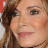

In [ ]:
print(len(dataFiles))
showImage(randint(0, len(dataFiles)))

In [ ]:
print(np.unique(age, return_counts=True))
print(np.unique(gender, return_counts=True))

(array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  95.,  96.,  99., 100., 101., 103.,
       105., 110., 111., 115., 116.]), array([1123,  482,  289,  273,  196,  131,  139,  263,  166,  156,   65,
        130,   81,  157,  177,  247,  158,  262,   98,  284,  346,  395,
        426,  859,  734, 2197,  615,  918,  570,  724,  350,  664,  143,
        409,  880,  483,  293,  325,  266,  526,  132,  266,  157,  100,
        440

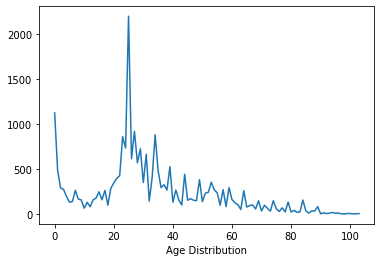

In [ ]:
plt.plot(np.unique(age, return_counts=True)[1])
plt.xlabel("Age Distribution")
plt.show()

In [ ]:
yData = np.zeros((len(dataFiles), 2, 1))  # Storing Age and Gender labels in a list

for i in range(len(dataFiles)):
    yData[i][0] = [age[i]]
    yData[i][1] = [gender[i]]

images = images / 255  # Normalizing image data

### Dividing into Training and Testing data (80:20)

In [ ]:
# Train Test Split function required same length of x[0] and y[0]
xTrain, xTest, yTrain, yTest = train_test_split(images, yData, test_size=0.2)

print(xTrain.shape, yTrain.shape)
print(yTrain[0:10])

# Changing the shape of yTrain and yTest as required by the model
yTrain = [yTrain[:, 0], yTrain[:, 1]]
yTest = [yTest[:, 0], yTest[:, 1]]
# print(yTrain.shape)
print(yTrain[0:10])

(18966, 48, 48, 3) (18966, 2, 1)
[[[ 3.]
  [ 0.]]

 [[26.]
  [ 1.]]

 [[37.]
  [ 0.]]

 [[43.]
  [ 0.]]

 [[34.]
  [ 0.]]

 [[56.]
  [ 1.]]

 [[71.]
  [ 1.]]

 [[67.]
  [ 0.]]

 [[65.]
  [ 0.]]

 [[55.]
  [ 0.]]]
[array([[ 3.],
       [26.],
       [37.],
       ...,
       [ 1.],
       [42.],
       [10.]]), array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [1.]])]


## Model Building

In [ ]:
input = Input((48, 48, 3))

conv = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input)
mpool = MaxPooling2D(pool_size=(2, 2))(conv)
drop = Dropout(0.1)(mpool)

conv = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(drop)
mpool = MaxPooling2D(pool_size=(2, 2))(conv)
drop = Dropout(0.1)(mpool)

conv = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(drop)
mpool = MaxPooling2D(pool_size=(2, 2))(conv)
drop = Dropout(0.1)(mpool)

conv = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(drop)
mpool = MaxPooling2D(pool_size=(2, 2))(conv)
drop = Dropout(0.1)(mpool)

flat = Flatten()(drop)

dense1 = Dense(64, activation='relu')(flat)
drop1 = Dropout(0.2)(dense1)
outAge = Dense(1, activation='relu', name='AgeOut')(drop1)

dense2 = Dense(64, activation='relu')(flat)
drop2 = Dropout(0.2)(dense2)
outGen = Dense(1, activation='sigmoid', name='GenOut')(drop2)

model = Model(inputs=[input], outputs=[outAge, outGen])
model.compile(loss=['mae', 'binary_crossentropy'], optimizer='Adam', metrics=['Accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 24, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 24, 24, 32)   0           max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
saveModel = 'Detection.h5'
checkpointer = ModelCheckpoint(saveModel, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
earlyStopping = EarlyStopping(patience=75, monitor='val_loss', restore_best_weights=True)
callbacks = [checkpointer, earlyStopping]

In [ ]:
his = model.fit(xTrain, yTrain, batch_size=64, validation_data=(xTest, yTest), epochs=100, callbacks=[callbacks])

Epoch 1/100
297/297 [==============================] - 37s 12ms/step - loss: 17.4898 - AgeOut_loss: 16.7731 - GenOut_loss: 0.7168 - AgeOut_accuracy: 0.0000e+00 - GenOut_accuracy: 0.0000e+00 - val_loss: 15.1224 - val_AgeOut_loss: 14.4426 - val_GenOut_loss: 0.6798 - val_AgeOut_accuracy: 0.0000e+00 - val_GenOut_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 15.12239, saving model to Detection.h5
Epoch 2/100
297/297 [==============================] - 3s 10ms/step - loss: 13.9788 - AgeOut_loss: 13.3135 - GenOut_loss: 0.6652 - AgeOut_accuracy: 0.0000e+00 - GenOut_accuracy: 0.0000e+00 - val_loss: 10.3020 - val_AgeOut_loss: 9.7367 - val_GenOut_loss: 0.5653 - val_AgeOut_accuracy: 0.0000e+00 - val_GenOut_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 15.12239 to 10.30199, saving model to Detection.h5
Epoch 3/100
297/297 [==============================] - 3s 10ms/step - loss: 11.2544 - AgeOut_loss: 10.6734 - GenOut_loss: 0.5810 - AgeOut_accuracy: 0.0000e+00 - GenOut_a

### Evaluating model

In [ ]:
model.evaluate(xTest, yTest)

149/149 [==============================] - 1s 3ms/step - loss: 6.9451 - AgeOut_loss: 6.6656 - GenOut_loss: 0.2795 - AgeOut_accuracy: 0.0000e+00 - GenOut_accuracy: 0.0023


[6.945124626159668,
 6.6656365394592285,
 0.2794894278049469,
 0.0,
 0.002319696359336376]

## Predicting test images

In [ ]:
model = load_model("Detection.h5")

In [ ]:
pred = model.predict(xTest)
predFinal = []

for i in range(len(pred[0])):
    predFinal.append(int(np.round(pred[0][i])))

In [ ]:
with open('imagesBGR.npy', 'rb') as f:
    origImages = np.load(f, allow_pickle=True)

In [ ]:
def predictImage(index):
    cv2_imshow(origImages[index])
    predIm = model.predict(np.array([images[index]]))
    
    g = "Male" if int(np.round(predIm[1][0])) == 0 else "Female"
    print(f"Predicted Age: {int(np.round(predIm[0][0]))} Gender: {g}")
    g = "Male" if gender[index] == 0 else "Female"
    print(f"Actual Age: {age[index]} Gender: {g}")

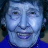

Predicted Age: 73 Gender: Female
Actual Age: 78.0 Gender: Female


In [ ]:
predictImage(randint(0, len(dataFiles)))